In [1]:
import time
import numpy as np
from heavy_tail_observations import BothSideWeibullNoise, BothSideParetoNoise, BothSideFrechetNoise
from heavy_tail_regressions import catoni_lin_reg, mom_lin_reg, pro, reg_lin_reg, trunc_lin_reg, trunc_reg

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
scale=1.
mean=0.
p=1.5
noise_type = 'frechet'

dim = 20
weight = np.random.randn(dim+1)
weight = weight/np.sqrt(weight.dot(weight))
    
if noise_type == 'weibull':
    weibull_noise = BothSideWeibullNoise(alpha=p+0.1,scale=scale,mean=mean,p=p)
    get_observation = lambda x: x.dot(weight) + weibull_noise.sample()
elif noise_type == 'pareto':
    pareto_noise = BothSideParetoNoise(alpha=p+0.1,scale=scale,mean=mean,p=p)
    get_observation = lambda x: x.dot(weight) + pareto_noise.sample()
elif noise_type == 'frechet':
    frechet_noise = BothSideFrechetNoise(alpha=p+0.1,scale=scale,mean=mean,p=p)
    get_observation = lambda x: x.dot(weight) + frechet_noise.sample()
    
x_list = np.zeros((10000,dim+1)) #
x_list[:,0] = 1.
x_list[:,1] = np.linspace(-10.,10., 10000)
mean_list = x_list.dot(weight)

n = 10000
x_data = 5.*np.random.randn(n,dim+1)
x_data[:,0] = 1.
y_data = [get_observation(x) for x in x_data]

Catoni RMS: 0.010723, Time: 37.974973
MoM RMS: 0.611594, Time: 2.908203
PRo RMS: 0.162101, Time: 15.898893
Reg RMS: 0.099001, Time: 0.001808
Trunc Lin RMS: 0.025123, Time: 2.861331
Trunc RMS: 0.051787, Time: 8.101502


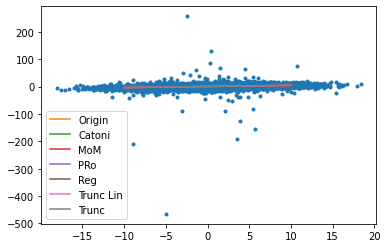

In [5]:
optim_names = ['Catoni', 'MoM', 'PRo', 'Reg', 'Trunc Lin', 'Trunc']
optim_params = [{'beta':1.},
                {'lam':1.,'k':10},
                {'lam':1.,'beta':1.},
                {'lam':1.},
                {'lam':1.,'beta':1.},
                {'lam':1.}]
optims = [catoni_lin_reg, mom_lin_reg, pro, reg_lin_reg, trunc_lin_reg, trunc_reg]
# optim_names = ['PRo','PRo','PRo','PRo','PRo']
# optim_params = [{'lam':1.,'beta':100},
#                 {'lam':1.,'beta':10},
#                 {'lam':1.,'beta':1},
#                 {'lam':1.,'beta':.1},
#                 {'lam':1.,'beta':.01}]
# optims = [pro,pro,pro,pro,pro]

plt.plot(x_data[:,1], y_data, '.')
plt.plot(x_list[:,1], mean_list, '-', label='Origin')
for optim, optim_param, optim_name  in zip(optims,optim_params,optim_names):
    start = time.time()
    est_mean_list, w_hat = optim(*(x_data,y_data,x_list,p),**optim_param)
    end = time.time()
    error = np.mean(np.abs(est_mean_list - mean_list))
    plt.plot(x_list[:,1], est_mean_list, '-', label=optim_name)
    print('{} RMS: {:.06f}, Time: {:.06f}'.format(optim_name, error, end-start))
    
# plt.xlim([-10.,10.])
# plt.ylim([-11.,11.])
plt.legend()
plt.show()